In [1]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_topvecs, load_all_bstr_arrs
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42})
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["DATE_TOPVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yijingch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yijingch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/date-topvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [2]:
from src.utils.dict_configuration import dictionary2016, dictionary2020

TOPICS2DROP = [
    "election_campaign", "general_controversies", "no_topic", 
    "forestry", "land_water_management", "agriculture", "housing", 
    "transportation", "culture"]

TOPICS2DROP_IDX2016 = [dictionary2016.topic2index[x] for x in TOPICS2DROP]
TOPICS2DROP_IDX2020 = [dictionary2020.topic2index[x] for x in TOPICS2DROP]

Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1426
Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1453


In [3]:
topvec_dfs2016 = load_all_topvecs(year=2016, topvec_fpath=INPUT_FPATH, normalize_by_unit=True)
topvec_dfs2020 = load_all_topvecs(year=2020, topvec_fpath=INPUT_FPATH, normalize_by_unit=True)

bstr_arrs2016 = load_all_bstr_arrs(year=2016, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)
bstr_arrs2020 = load_all_bstr_arrs(year=2020, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from collections import Counter

# https://rishi-a.github.io/2020/05/25/granger-causality.html

def granger_causality_all_topics(arr1, arr2, dictionary, maxlag=5, topics2skip=TOPICS2DROP, verbose=False, p_thres=.01, postfix=""):
    arr1 = np.diff(arr1, axis=0)
    arr2 = np.diff(arr2, axis=0)

    topics2test = list(set(dictionary.topics) - set(TOPICS2DROP))
    out_df = pd.DataFrame()
    out_df["topic"] = topics2test 
    p_values = []

    for topic in topics2test:
        topic_idx = dictionary.topic2index[topic]
        test_df = pd.DataFrame()
        test_df["ts_Y"] = arr1[:,topic_idx]
        test_df["ts_X"] = arr2[:,topic_idx]
        # whether the time series in the second column Granger causes the time series in the first column
        if test_df["ts_X"].nunique() > 1 and test_df["ts_Y"].nunique() > 1:
            # print(test_df)
            test_result = grangercausalitytests(test_df, maxlag=maxlag, verbose=False)
            p = [round(test_result[i+1][0]["ssr_ftest"][1],4) for i in range(maxlag)]
            if verbose: print(f"topic = {topic}, p = {p}")
        else:
            p = [np.NaN for i in range(maxlag)]
        p_values.append(p)

    out_df[f"p_value{postfix}"] = p_values
    out_df[f"opt_lag{postfix}"] = out_df[f"p_value{postfix}"].map(lambda x: np.where(np.array(x) == np.array(x).min())[0]+1)
    out_df[f"opt_lag_sig{p_thres}{postfix}"] = out_df.apply(lambda x: [y for y in x[f"opt_lag{postfix}"] if x[f"p_value{postfix}"][y-1]<p_thres], axis=1)
    return out_df

def granger_causality_for_df(df1, df2, dictionary, maxlag=5, topics2skip=TOPICS2DROP, verbose=False, p_thres=.01):
    arr1 = np.array(df1["majority_topvec"].tolist())
    arr2 = np.array(df2["majority_topvec"].tolist())
    out_df = granger_causality_all_topics(
        arr1, arr2, 
        dictionary=dictionary, 
        maxlag=maxlag, 
        topics2skip=topics2skip, 
        verbose=verbose, 
        p_thres=p_thres)
    return out_df

def granger_causality_for_bstr_arrs(bstr_arrs1, bstr_arrs2, dictionary, maxlag=5, topics2skip=TOPICS2DROP, verbose=False, p_thres=.01):
    n_runs = bstr_arrs1.shape[0]
    big_out_df = pd.DataFrame()
    for r in range(n_runs):
        out_df = granger_causality_all_topics(
            bstr_arrs1[r], bstr_arrs2[r],
            dictionary=dictionary, maxlag=maxlag, 
            topics2skip=topics2skip, verbose=verbose, p_thres=p_thres, postfix=str(r))
        big_out_df = pd.concat([big_out_df, out_df], axis=1)
        if r == 0:
            topics = out_df["topic"].tolist()
    big_out_df.drop(columns="topic", inplace=True)
    big_out_df["topic"] = topics
    big_out_df[f"ls_opt_lag_sig{p_thres}"] = big_out_df.apply(lambda x: [i for ls in [x[f"opt_lag_sig{p_thres}{r}"] for r in range(200)] for i in ls], axis=1)
    big_out_df[f"count_opt_lag_sig{p_thres}"] = big_out_df[f"ls_opt_lag_sig{p_thres}"].map(lambda x: Counter(x))
    for lag in range(maxlag):
        big_out_df[f"lag{lag+1}_count{p_thres}"] = big_out_df[f"count_opt_lag_sig{p_thres}"].map(lambda x: x[lag+1] if lag+1 in x.keys() else 0)
    return big_out_df

## Credibility groups

In [5]:
year = 2020
if year == 2016:
    cand1 = "trump"
    cand2 = "clinton"
    dictionary = dictionary2016
    topvec_dfs = topvec_dfs2016
    bstr_arrs = bstr_arrs2016
elif year == 2020:
    cand1 = "biden"
    cand2 = "trump"
    dictionary = dictionary2020
    topvec_dfs = topvec_dfs2020
    bstr_arrs = bstr_arrs2020

THRES = 0.05

trad2lowc_cand1 = granger_causality_for_df(topvec_dfs["headline"][0][1], topvec_dfs["headline"][0][2], dictionary, p_thres=THRES)
lowc2trad_cand1 = granger_causality_for_df(topvec_dfs["headline"][0][2], topvec_dfs["headline"][0][1], dictionary, p_thres=THRES)

trad2lowc_cand2 = granger_causality_for_df(topvec_dfs["headline"][1][1], topvec_dfs["headline"][1][2], dictionary, p_thres=THRES)
lowc2trad_cand2 = granger_causality_for_df(topvec_dfs["headline"][1][2], topvec_dfs["headline"][1][1], dictionary, p_thres=THRES)

bstr_trad2lowc_cand1 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][0][1], bstr_arrs["headline"][0][2], dictionary, p_thres=THRES)
bstr_lowc2trad_cand1 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][0][2], bstr_arrs["headline"][0][1], dictionary, p_thres=THRES)

bstr_trad2lowc_cand2 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][1][1], bstr_arrs["headline"][1][2], dictionary, p_thres=THRES)
bstr_lowc2trad_cand2 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][1][2], bstr_arrs["headline"][1][1], dictionary, p_thres=THRES)

/var/folders/6j/_fm4pddj4fd8_hv1t_6zy1r80000gn/T/ipykernel_80561/3762519271.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  big_out_df["topic"] = topics
/var/folders/6j/_fm4pddj4fd8_hv1t_6zy1r80000gn/T/ipykernel_80561/3762519271.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  big_out_df["topic"] = topics
/var/folders/6j/_fm4pddj4fd8_hv1t_6zy1r80000gn/T/ipykernel_80561/3762519271.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [6]:
# left2right_cand1 = granger_causality_for_df(topvec_dfs["headline"][0][5], topvec_dfs["headline"][0][3], dictionary, p_thres=THRES)
# right2left_cand1 = granger_causality_for_df(topvec_dfs["headline"][0][3], topvec_dfs["headline"][0][5], dictionary, p_thres=THRES)

# left2right_cand2 = granger_causality_for_df(topvec_dfs["headline"][1][5], topvec_dfs["headline"][1][3], dictionary, p_thres=THRES)
# right2left_cand2 = granger_causality_for_df(topvec_dfs["headline"][1][3], topvec_dfs["headline"][1][5], dictionary, p_thres=THRES)

# bstr_left2right_cand1 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][0][5], bstr_arrs["headline"][0][3], dictionary, p_thres=THRES)
# bstr_right2left_cand1 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][0][3], bstr_arrs["headline"][0][5], dictionary, p_thres=THRES)

# bstr_left2right_cand2 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][1][5], bstr_arrs["headline"][1][3], dictionary, p_thres=THRES)
# bstr_right2left_cand2 = granger_causality_for_bstr_arrs(bstr_arrs["headline"][1][3], bstr_arrs["headline"][1][5], dictionary, p_thres=THRES)

In [7]:
def generate_output_df(dictionary, labela, labelb, a2b_cand, b2a_cand, thres=THRES):
    output_df = pd.DataFrame() 
    output_df["topic"] = dictionary.topics

    output_df = output_df.merge(a2b_cand[["topic",f"opt_lag_sig{thres}"]])
    output_df[f"led_by_{labela}"] = output_df[f"opt_lag_sig{thres}"].map(lambda x: 1 if len(x) > 0 else 0)
    output_df.drop(columns=f"opt_lag_sig{thres}", inplace=True)

    output_df = output_df.merge(b2a_cand[["topic",f"opt_lag_sig{thres}"]])
    output_df[f"led_by_{labelb}"] = output_df[f"opt_lag_sig{thres}"].map(lambda x: 1 if len(x) > 0 else 0)
    output_df.drop(columns=f"opt_lag_sig{thres}", inplace=True)

    output_df["mutual"] = output_df.apply(lambda x: 1 if x[f"led_by_{labela}"] + x[f"led_by_{labelb}"] == 2 else 0, axis=1)
    output_df["no_relation"] = output_df.apply(lambda x: 1 if x[f"led_by_{labela}"] + x[f"led_by_{labelb}"] == 0 else 0, axis=1)

    output_df[f"led_by_{labela}_only"] = output_df[f"led_by_{labela}"] - output_df["mutual"]
    output_df[f"led_by_{labelb}_only"] = output_df[f"led_by_{labelb}"] - output_df["mutual"]

    return output_df[["topic", f"led_by_{labela}_only", f"led_by_{labelb}_only", "mutual", "no_relation"]]

def generate_output_df_bstr(dictionary, labela, labelb, bstr_a2b_cand, bstr_b2a_cand, thres=THRES):
    output_df_all = pd.DataFrame()
    output_df_all["topic"] = dictionary.topics
    nruns = 200
    for r in range(nruns):
        a2b_cand = bstr_a2b_cand[["topic",f"opt_lag_sig{thres}{r}"]].copy()
        a2b_cand.rename(columns={f"opt_lag_sig{thres}{r}": f"opt_lag_sig{thres}"}, inplace=True)
        b2a_cand = bstr_b2a_cand[["topic",f"opt_lag_sig{thres}{r}"]].copy()
        b2a_cand.rename(columns={f"opt_lag_sig{thres}{r}": f"opt_lag_sig{thres}"}, inplace=True)
        output_df_r = generate_output_df(dictionary, labela, labelb, a2b_cand, b2a_cand, thres=thres)
        output_df_r.rename(columns={
            f"led_by_{labela}_only": f"led_by_{labela}_only_{r}",
            f"led_by_{labelb}_only": f"led_by_{labelb}_only_{r}",
            "mutual": f"mutual_{r}",
            "no_relation": f"no_relation_{r}"}, inplace=True)
        output_df_all = pd.concat([output_df_all, output_df_r], axis=1)
        if r != nruns-1:
            output_df_all.drop(columns="topic", inplace=True)

    output_df_all[f"led_by_{labela}_only"] = output_df_all.apply(
        lambda x: np.sum([x[f"led_by_{labela}_only_{r}"] for r in range(nruns)]), axis=1)
    output_df_all[f"led_by_{labelb}_only"] = output_df_all.apply(
        lambda x: np.sum([x[f"led_by_{labelb}_only_{r}"] for r in range(nruns)]), axis=1)
    output_df_all["mutual"] = output_df_all.apply(
        lambda x: np.sum([x[f"mutual_{r}"] for r in range(nruns)]), axis=1)
    output_df_all["no_relation"] = output_df_all.apply(
        lambda x: np.sum([x[f"no_relation_{r}"] for r in range(nruns)]), axis=1)

    cols = ["topic", f"led_by_{labela}_only", f"led_by_{labelb}_only", "mutual", "no_relation"]

    return output_df_all[cols].dropna()

In [8]:
labela = "trad"
labelb = "lowc"

cred1_output = generate_output_df(dictionary, labela=labela, labelb=labelb,
    a2b_cand=trad2lowc_cand1, b2a_cand=lowc2trad_cand1, thres=THRES)

cred2_output = generate_output_df(dictionary, labela=labela, labelb=labelb,
    a2b_cand=trad2lowc_cand2, b2a_cand=lowc2trad_cand2, thres=THRES)

bstr_cred1_output = generate_output_df_bstr(
    dictionary, labela=labela, labelb=labelb,
    bstr_a2b_cand=bstr_trad2lowc_cand1, bstr_b2a_cand=bstr_lowc2trad_cand1, thres=THRES)

bstr_cred2_output = generate_output_df_bstr(
    dictionary, labela=labela, labelb=labelb,
    bstr_a2b_cand=bstr_trad2lowc_cand2, bstr_b2a_cand=bstr_lowc2trad_cand2, thres=THRES)

bstr_cred1_output.rename(columns={
    f"led_by_{labela}_only": f"led_by_{labela}_only_{cand1}",
    f"led_by_{labelb}_only": f"led_by_{labelb}_only_{cand1}",
    "mutual": f"mutual_{cand1}",
    "no_relation": f"no_relation_{cand1}"}, inplace=True)
bstr_cred2_output.rename(columns={
    f"led_by_{labela}_only": f"led_by_{labela}_only_{cand2}",
    f"led_by_{labelb}_only": f"led_by_{labelb}_only_{cand2}",
    "mutual": f"mutual_{cand2}",
    "no_relation": f"no_relation_{cand2}"}, inplace=True)

In [9]:
# labela = "left"
# labelb = "right"

# ideo1_output = generate_output_df(dictionary, labela=labela, labelb=labelb,
#     a2b_cand=left2right_cand1, b2a_cand=right2left_cand1, thres=THRES)

# ideo2_output = generate_output_df(dictionary, labela=labela, labelb=labelb,
#     a2b_cand=left2right_cand2, b2a_cand=right2left_cand2, thres=THRES)

# bstr_ideo1_output = generate_output_df_bstr(dictionary, labela=labela, labelb=labelb,
#     bstr_a2b_cand=bstr_left2right_cand1, bstr_b2a_cand=bstr_right2left_cand1, thres=THRES)

# bstr_ideo2_output = generate_output_df_bstr(dictionary, labela=labela, labelb=labelb,
#     bstr_a2b_cand=bstr_left2right_cand2, bstr_b2a_cand=bstr_right2left_cand2, thres=THRES)

# bstr_ideo1_output.rename(columns={
#     f"led_by_{labela}_only": f"led_by_{labela}_only_{cand1}",
#     f"led_by_{labelb}_only": f"led_by_{labelb}_only_{cand1}",
#     "mutual": f"mutual_{cand1}",
#     "no_relation": f"no_relation_{cand1}"}, inplace=True)
# bstr_ideo2_output.rename(columns={
#     f"led_by_{labela}_only": f"led_by_{labela}_only_{cand2}",
#     f"led_by_{labelb}_only": f"led_by_{labelb}_only_{cand2}",
#     "mutual": f"mutual_{cand2}",
#     "no_relation": f"no_relation_{cand2}"}, inplace=True)

In [10]:
topic_sum1 = np.sum(topvec_dfs["headline"][0][0]["majority_topvec"], axis=0)
topic_sum2 = np.sum(topvec_dfs["headline"][1][0]["majority_topvec"], axis=0)
topic_sum = topic_sum1 + topic_sum2
TOPIC_SUM = {dictionary.index2topic[str(i)]:v for i,v in enumerate(topic_sum)}

plot_df = bstr_cred1_output.merge(bstr_cred2_output)
plot_df["sum"] = plot_df["topic"].map(lambda x: TOPIC_SUM[x])
plot_df.sort_values(by="sum", ascending=False, inplace=True)
plot_df = plot_df.head(10)

# plot_df = bstr_ideo1_output.merge(bstr_ideo2_output)
# plot_df["sum"] = plot_df["topic"].map(lambda x: TOPIC_SUM[x])
# plot_df.sort_values(by="sum", ascending=False, inplace=True)
# plot_df = plot_df.head(10)

In [11]:
ABBR_MAP = {
    "healthcare":"HLTH", 
    "election_campaign":"ELEC", 
    "general_controversies":"GENC", 
    "trump_controversies":"TRUC", 
    "civil_rights":"CIVR", 
    "crime":"CRIM", 
    "clinton_controversies":"CLIC", 
    "biden_controversies":"BIDC",
    "intl_affairs":"INTL", 
    "government_ops":"GVOP", 
    "energy":"ENRG", 
    "economy":"ECON", 
    "sstc":"SSTC", 
    "foreign_trade":"FRTR", 
    "immigration":"IMMI", 
    "social_welfare":"SOWL", 
    "education":"EDUC", 
    "environment":"ENVR", 
    "labour":"LABR", 
    "defence":"DEFC", 
    "religion":"RELG", 
    "agriculture":"AGRI", 
    "housing":"HOUS", 
    "transportation":"TRSP", 
    "land_water_management":"LWMN", 
    "forestry":"FRST", 
    "culture":"CLTR", 
    "no_topic":"NA", 
}

## Between lowc and trad

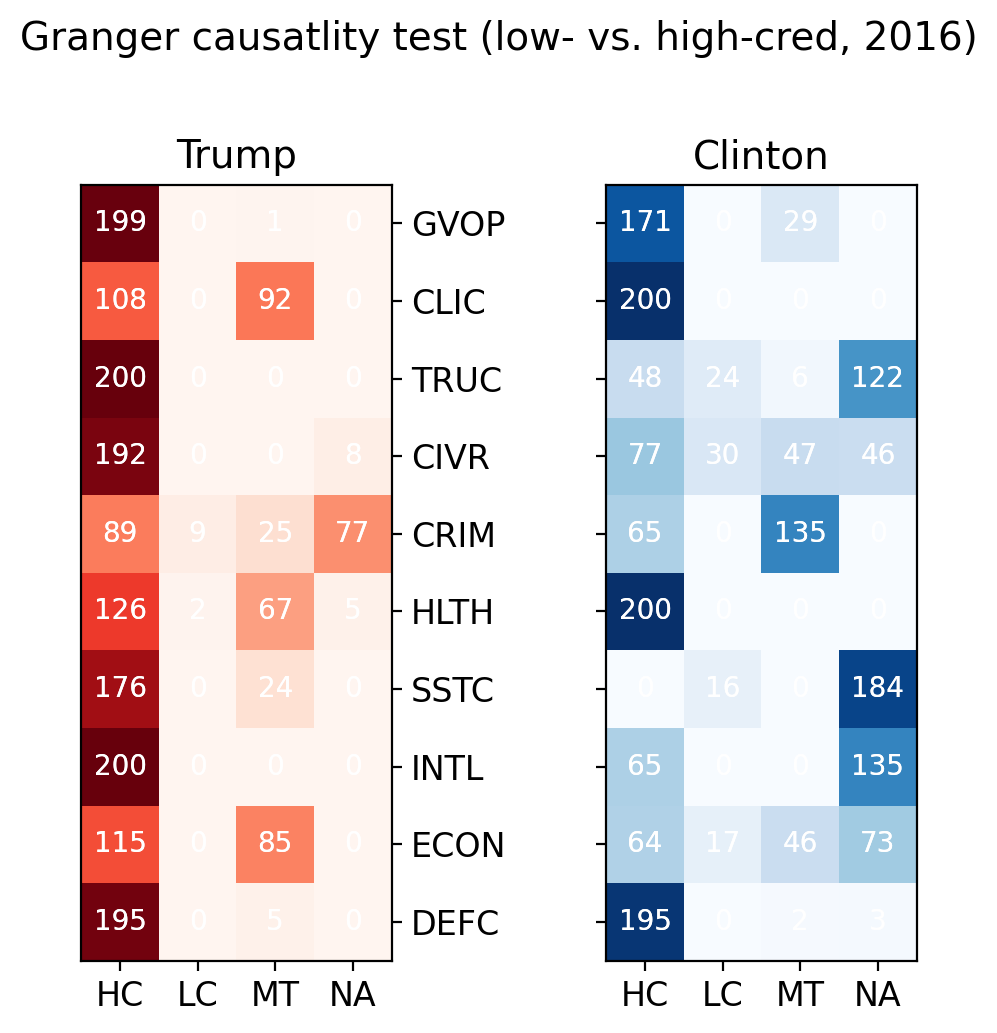

In [12]:
# # 2016
fig,ax = plt.subplots(figsize=(5,5), ncols=2, sharey=True)
mat1 = plot_df[[f"led_by_trad_only_{cand1}", f"led_by_lowc_only_{cand1}", f"mutual_{cand1}", f"no_relation_{cand1}"]].values
mat2 = plot_df[[f"led_by_trad_only_{cand2}", f"led_by_lowc_only_{cand2}", f"mutual_{cand2}", f"no_relation_{cand2}"]].values
ax[0].imshow(mat1,cmap="Reds")
ax[1].imshow(mat2,cmap="Blues")

for (j,i),label in np.ndenumerate(mat1):
    ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
    ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
for (j,i),label in np.ndenumerate(mat2):
    ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
    ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)

TICKS = ["HC", "LC", "MT", "NA"]
for i,cand in enumerate(["Trump", "Clinton"]):
    ax[i].set_xticks(range(len(TICKS)), TICKS, fontsize=12)
    ax[i].set_title(cand, fontsize=14)

ax[0].yaxis.tick_right()
ax[0].set_yticks(range(len(plot_df)), plot_df["topic"].map(lambda x: ABBR_MAP[x]), fontsize=12)
plt.suptitle("Granger causatlity test (low- vs. high-cred, 2016)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_FPATH + f"CRED_intermedia_granger_matrix{year}_pthres05.pdf", dpi=300, bbox_inches="tight")

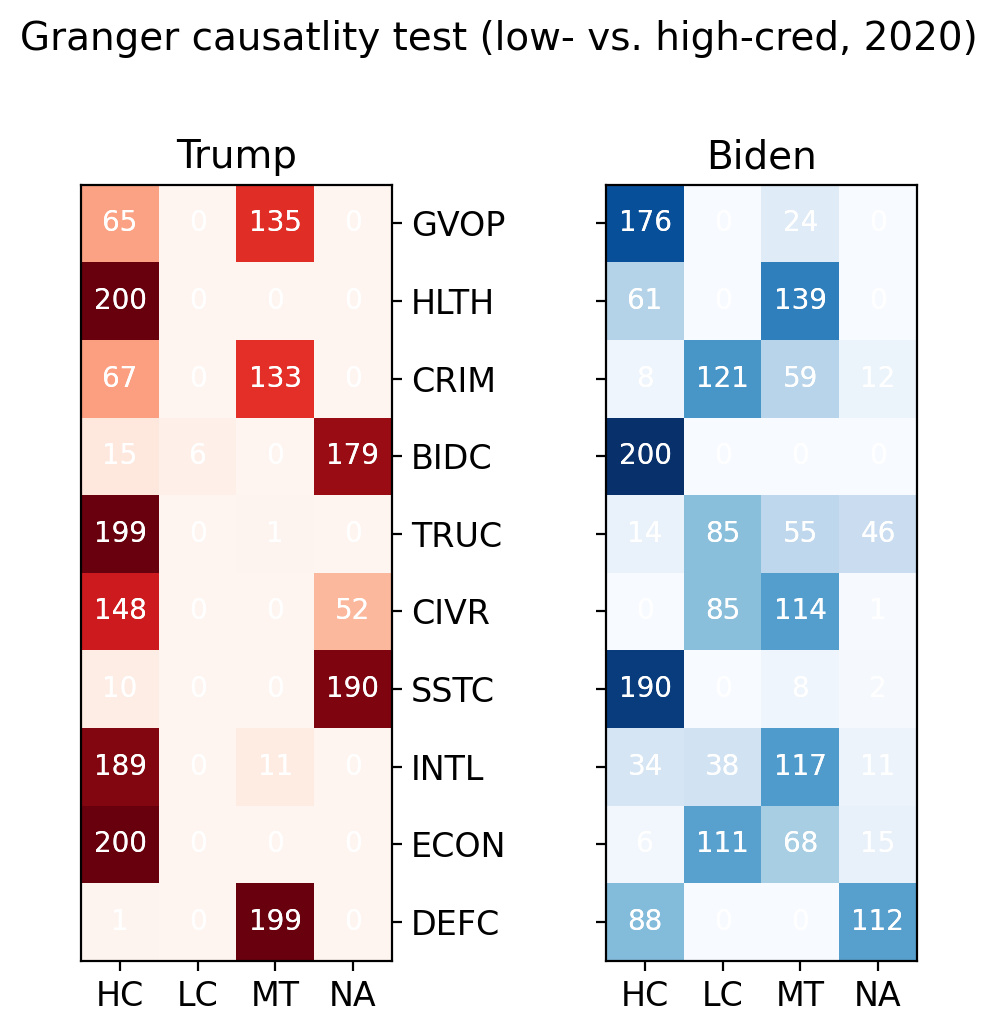

In [13]:
# # 2020
# fig,ax = plt.subplots(figsize=(5,5), ncols=2, sharey=True)
# mat1 = plot_df[[f"led_by_trad_only_{cand1}", f"led_by_lowc_only_{cand1}", f"mutual_{cand1}", f"no_relation_{cand1}"]].values
# mat2 = plot_df[[f"led_by_trad_only_{cand2}", f"led_by_lowc_only_{cand2}", f"mutual_{cand2}", f"no_relation_{cand2}"]].values
# ax[1].imshow(mat1,cmap="Blues")
# ax[0].imshow(mat2,cmap="Reds")

# for (j,i),label in np.ndenumerate(mat1):
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
# for (j,i),label in np.ndenumerate(mat2):
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)

# TICKS = ["HC", "LC", "MT", "NA"]
# for i,cand in enumerate(["Trump", "Biden"]):
#     ax[i].set_xticks(range(len(TICKS)), TICKS, fontsize=12)
#     ax[i].set_title(cand, fontsize=14)

# ax[0].yaxis.tick_right()
# ax[0].set_yticks(range(len(plot_df)), plot_df["topic"].map(lambda x: ABBR_MAP[x]), fontsize=12)
# plt.suptitle("Granger causatlity test (low- vs. high-cred, 2020)", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"CRED_intermedia_granger_matrix{year}_pthres05.pdf", dpi=300, bbox_inches="tight")

## Between left and right

In [14]:
# # 2016
# fig,ax = plt.subplots(figsize=(5,5), ncols=2, sharey=True)
# mat1 = plot_df[[f"led_by_left_only_{cand1}", f"led_by_right_only_{cand1}", f"mutual_{cand1}", f"no_relation_{cand1}"]].values
# mat2 = plot_df[[f"led_by_left_only_{cand2}", f"led_by_right_only_{cand2}", f"mutual_{cand2}", f"no_relation_{cand2}"]].values
# ax[0].imshow(mat1,cmap="Reds")
# ax[1].imshow(mat2,cmap="Blues")

# for (j,i),label in np.ndenumerate(mat1):
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
# for (j,i),label in np.ndenumerate(mat2):
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)

# TICKS = ["LF", "RT", "MT", "NA"]
# for i,cand in enumerate(["Trump", "Clinton"]):
#     ax[i].set_xticks(range(len(TICKS)), TICKS, fontsize=12)
#     ax[i].set_title(cand, fontsize=14)

# ax[0].yaxis.tick_right()
# ax[0].set_yticks(range(len(plot_df)), plot_df["topic"].map(lambda x: ABBR_MAP[x]), fontsize=12)
# plt.suptitle("Granger causatlity test (left vs. right, 2016)", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"IDEO_intermedia_granger_matrix{year}_pthres05.pdf", dpi=300, bbox_inches="tight")

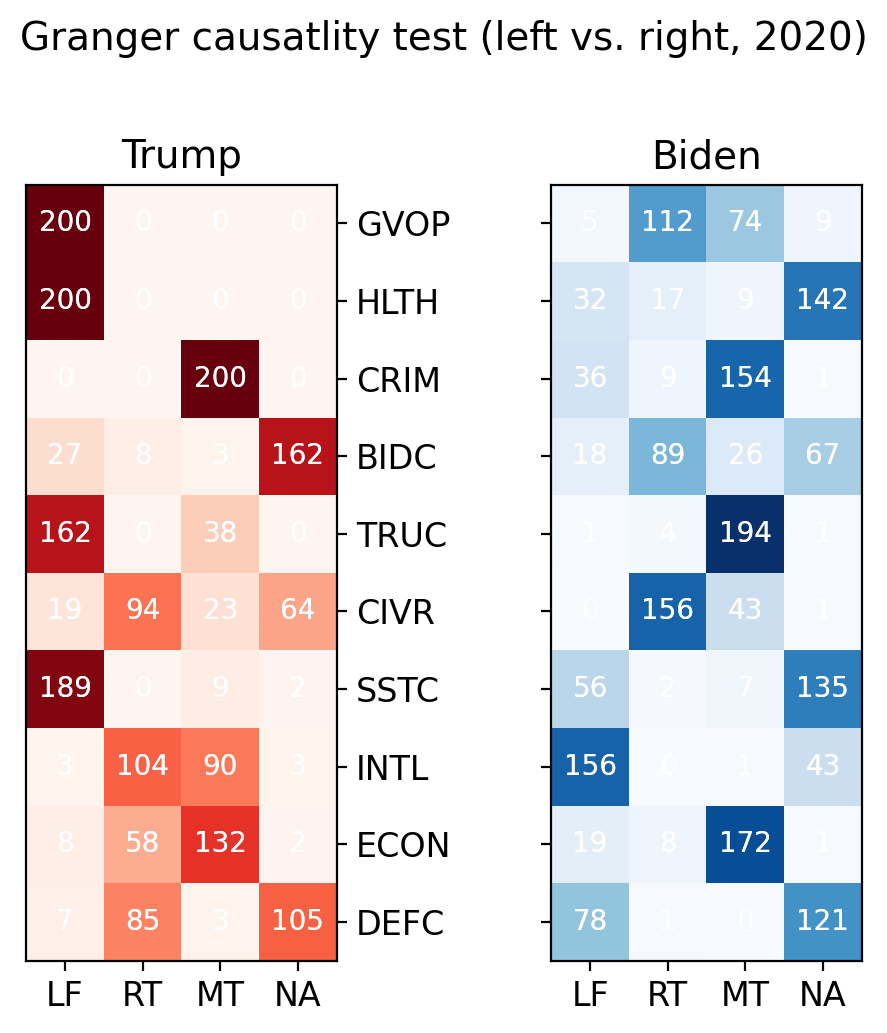

In [15]:
# # 2020
# fig,ax = plt.subplots(figsize=(5,5), ncols=2, sharey=True)
# mat1 = plot_df[[f"led_by_left_only_{cand1}", f"led_by_right_only_{cand1}", f"mutual_{cand1}", f"no_relation_{cand1}"]].values
# mat2 = plot_df[[f"led_by_left_only_{cand2}", f"led_by_right_only_{cand2}", f"mutual_{cand2}", f"no_relation_{cand2}"]].values
# ax[1].imshow(mat1,cmap="Blues")
# ax[0].imshow(mat2,cmap="Reds")

# for (j,i),label in np.ndenumerate(mat1):
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[1].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
# for (j,i),label in np.ndenumerate(mat2):
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)
#     ax[0].text(i,j,int(label),ha="center",va="center", color="white", fontsize=10)

# TICKS = ["LF", "RT", "MT", "NA"]
# for i,cand in enumerate(["Trump", "Biden"]):
#     ax[i].set_xticks(range(len(TICKS)), TICKS, fontsize=12)
#     ax[i].set_title(cand, fontsize=14)

# ax[0].yaxis.tick_right()
# ax[0].set_yticks(range(len(plot_df)), plot_df["topic"].map(lambda x: ABBR_MAP[x]), fontsize=12)
# plt.suptitle("Granger causatlity test (left vs. right, 2020)", fontsize=14, y=1.02)
# plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + f"IDEO_intermedia_granger_matrix{year}_pthres05.pdf", dpi=300, bbox_inches="tight")